# Predicting NHL success from the Canadian Hockey Leagues (CHL)

### Executive Summary:

A significant part of any sports teams’ success is effective player drafting and acquisition. The NHL is no different in this regard and has been ramping up the use of data analytics to help improve efficiency in these areas. In this project, I examined players from the Canadian Hockey League (CHL) (a composite of the Ontario Hockey League (OHL), Western Hockey League (WHL), and Quebec Major Junior Hockey League (QMJHL)) and built a classifier to predict whether or not a player would make it to the NHL and record at the minimum a 20 point season. There are a number of different ways to measure NHL success, Jonathan Willis makes the case that 200-games played in the NHL is a strong cut-off as to whether a prospect has “made it” in the NHL[5]. I wanted to look at offensive capabilities, so I decided upon the 20 point mark which only 38% (612/1591) of players reached this mark from NHL seasons 2011-2016 [6]. I found that only about 7% of players from our training CHL dataset ever actually record 20+ point season in the NHL, and that some of the best indicators for this criteria of success are age, assists per game, power play assists per game and power play goals per game. Unsurprisingly, I found that while it was very easy to predict the players who were unlikely to make it, the players who did reach the 20+ point mark had a very wide range of statistical production at the CHL level, making it very hard to predict the “winners” from the cohort.

There are some other interesting analyses on player prospecting. Most similarly, the proposed Prospect Cohort Success (PCS) model from Josh Weissbock, looks at evaluating CHL players by comparing them to existing NHL players and using that score to predict the probability that the player will reach the NHL[2]. Another useful tool and popular approach for evaluating prospects success is to project their expected scoring capabilities were they to jump to the NHL[8] or to determine how many goals is worth in one league translates to another[9]. Below I will walk through the data used in this process, the evaluation of models and the information we can glean from this study.

### Data:

In order to build our CHL classifier model, we had to pull historical data from the CHL leagues. I was able to pull data directly from the three leagues websites ohl.ca[10], ontariohockeyleague.com[11] and theqmjhl.ca[12]. The websites had data back to the 1997-98 seasons, and as such that was the beginning of my data for modeling. I looked for some general baseline on peak performance in the NHL to see where an appropriate cut-off may be for the upper end. One estimation suggest that peak per-game point performance peaks at ages 24-26 [7]. Using this guideline, I used the 2004-05 season as the cutoff on the upper end of the data. With the youngest of these players being ~29 years of age at the time we pulled their NHL performance, I worked under the assumption that the players from the 98-05 seasons, had already reached their full potential.

I pulled NHL data from hockey-reference.com[13] from 97-98 through 2015-16 NHL seasons. Once I had the CHL datasets and NHL datasets loaded, I put the NHL dataset into a pivot table, with the player as the index and the aggregating fuction as a max function, so that we have a list of NHL players with their highest full season point total from 98-16. From here I matched up the NHL max points season dataset with the CHL dataset on player's names to give us our target variable for the analysis. There were some manual connections that were necessary to ensure that players names from the hockey-reference database matched the CHL databases (e.g Pierre-Alexandre Parenteau & P.A. Parenteau). There were also instances where it was necessary to distinguish between two players with the same name. From here we had our master CHL database with our target variable attached to the dataframe.

### Modeling Process:

From here I will discuss the model selection and feature selection process.

### Library Import

In [582]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier

%matplotlib inline

### Data Import

In [307]:
chl = pd.read_csv('../Combined CHL Data/chl_98_16_pts_bin.csv')
chl = chl.sort_values(by='season_start_date', ascending=False).reset_index() # reorder by season and reset index

### Narrow down the stats we will explore for the analysis

At this stage in the process we had to select what statistics we wanted to work with. A number of statistics such as shots and shot percentage were not tracked during the 98-05 seasons and were not consistent across all three leagues. What we were left with was the below list.

In [308]:
keep_list = [ 'full_name', 'birthdate', 'rookie', 'points_per_game', 'position', 'penalty_minutes_per_game', 
             'games_played','weight', 'season', 'team_id', 'points', 'assists', 'goals', 'power_play_assists', 
             'season_start_date', 'power_play_goals', 'short_handed_assists', 'short_handed_goals', 'unassisted_goals', 'league', 
             'max_pt_season_bin', 'unassisted_goals', 'points', 'overtime_goals', 'empty_net_goals']

X = chl[keep_list]

In [309]:
# watermark for a base model w/ using player data from 98-05
# must run up to the "filter by season" section for this to run
b = pd.pivot_table(X_fin, index='full_name', aggfunc=np.mean).max_pt_season_bin.value_counts()
(b / sum(b)) * 100

0.0     92.999110
20.0     3.619104
40.0     1.720558
60.0     1.661228
Name: max_pt_season_bin, dtype: float64

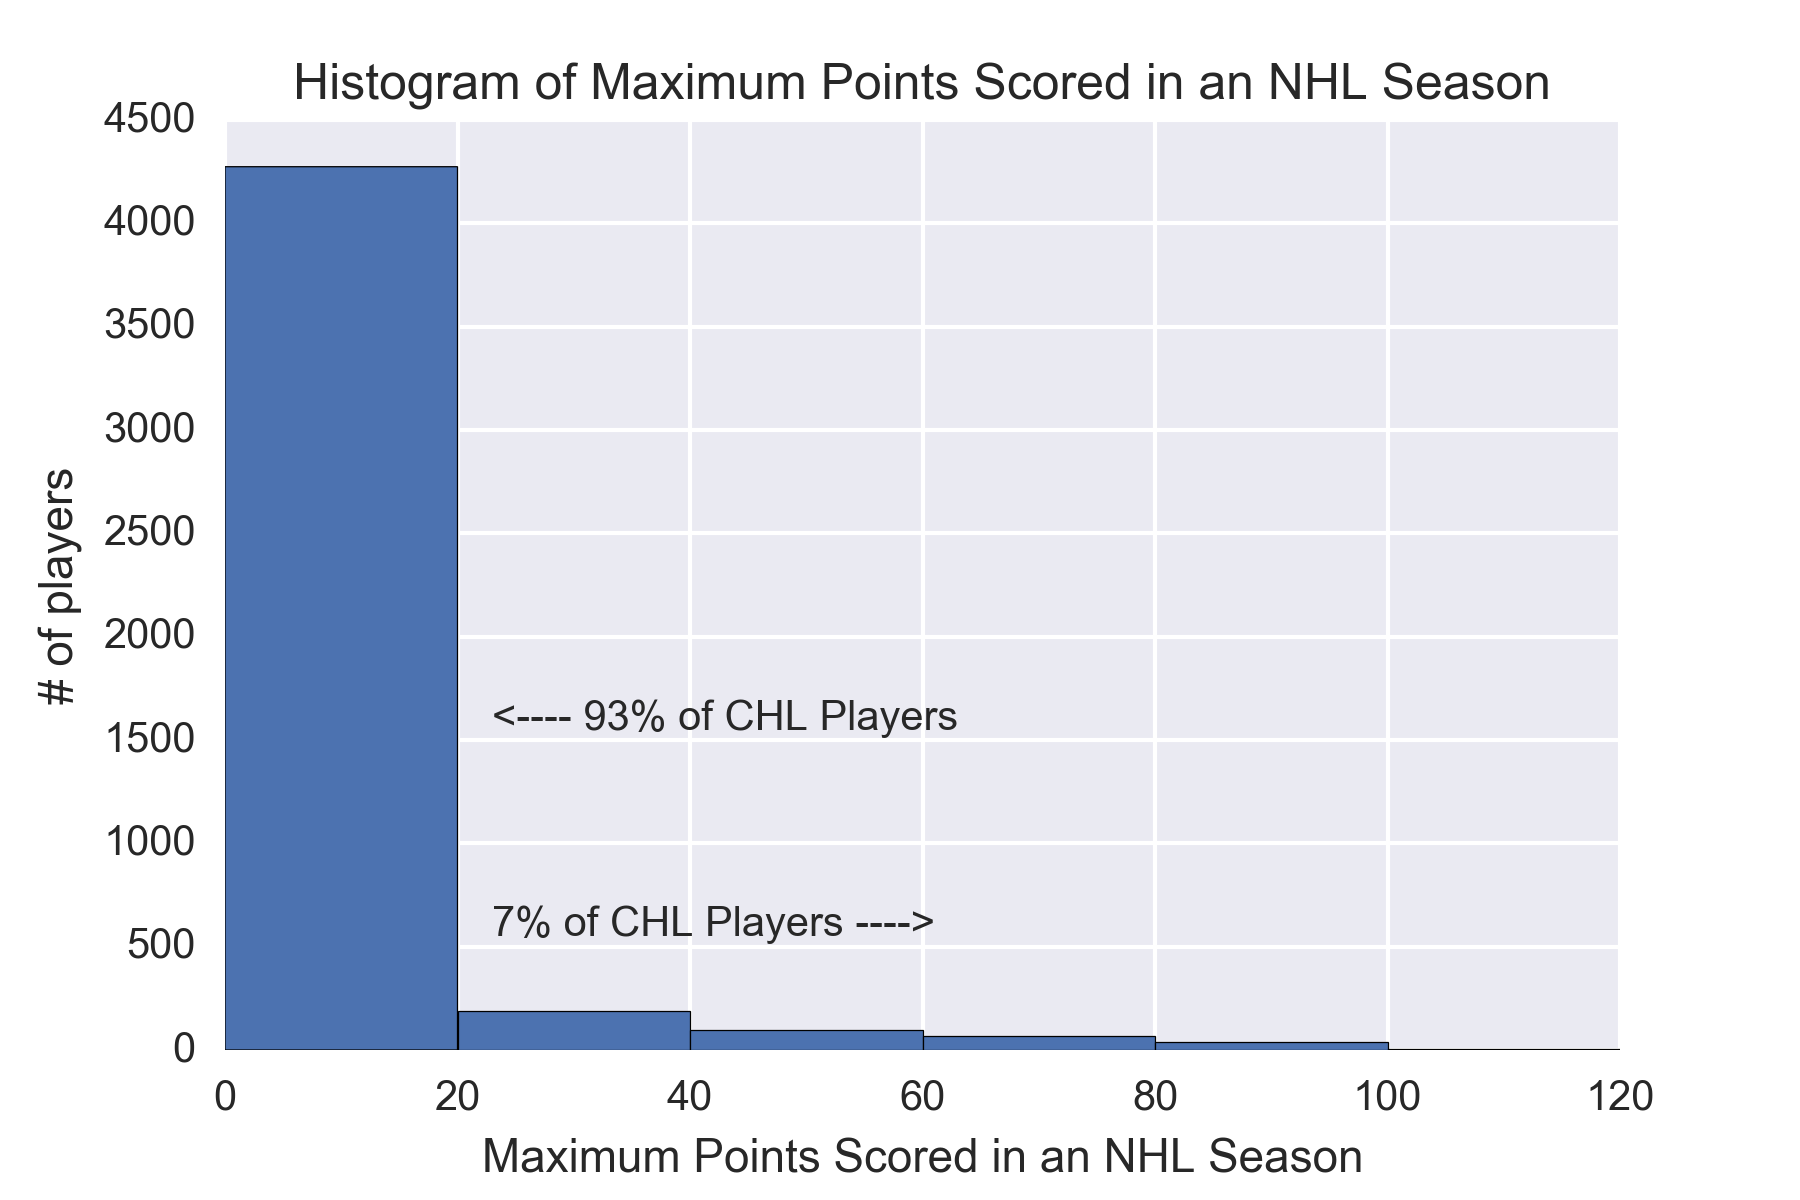

In [310]:
Image('/Users/gmaclenn/Documents/capstone-project/max_pts_hist.png', width=800)

### Converting Date Objects (Birthday & Season Start Date)

In this area, I made sure we converted objects to datetime so that we could calculate season start date, birthdate, and season start age for each player. Using birthdate instead of year will give us greater granularity on players performance at a given age.

In [311]:
# convert birthdate and season start date to datetime
X.loc[:, 'birthdate'] = pd.to_datetime(X.loc[:, 'birthdate'])
X.loc[:, 'season_start_date'] = pd.to_datetime(X.loc[:, 'season_start_date'])

In [312]:
def age_diff(season_start, birthdate):
    # returns the difference between season start date and birthday
    return (season_start - birthdate)

# gets the age differences between the start date and draft date
X.loc[:, 'season_start_age'] = age_diff(X.loc[:,'season_start_date'], X.loc[:,'birthdate'])

### Create per game stats and per game squared

In [313]:
def per_game_stats(games_played, stat_column):
    # returns the difference between season start date and birthday
    return (stat_column / games_played)

X.loc[:, 'apg'] = per_game_stats(X.loc[:,'games_played'], X.loc[:,'assists'])
X.loc[:, 'gpg'] = per_game_stats(X.loc[:, 'games_played'], X.loc[:, 'goals'])
X.loc[:, 'sh_gpg'] = per_game_stats(X.loc[:, 'games_played'], X.loc[:, 'short_handed_goals'])
X.loc[:, 'sh_apg'] = per_game_stats(X.loc[:, 'games_played'], X.loc[:, 'short_handed_assists'])
X.loc[:, 'pp_apg'] = per_game_stats(X.loc[:, 'games_played'], X.loc[:, 'power_play_assists'])
X.loc[:, 'pp_gpg'] = per_game_stats(X.loc[:, 'games_played'], X.loc[:, 'power_play_goals'])

# create  per game values squared to try and isolate top performers better
X.loc[:, 'apg2'] = X.loc[:, 'apg'].apply(lambda x: pow(x,2))
X.loc[:, 'gpg2'] = X.loc[:, 'gpg'].apply(lambda x: pow(x,2))
X.loc[:, 'pp_apg2'] = X.loc[:, 'pp_apg'].apply(lambda x: pow(x,2))
X.loc[:, 'pp_gpg2'] = X.loc[:, 'pp_gpg'].apply(lambda x: pow(x,2))

### Convert the datetime object from days to years for ease of understanding

In [314]:
# **ONLY RUN ONCE**
# convert season start_age to years
X.loc[:, 'season_start_age'] = [(i / np.timedelta64(1, 'D')) / 365 for i in X.season_start_age] 

### Drop the columns we modified but will no longer need

In [315]:
X = X.drop(['season_start_date', 'short_handed_goals', 'short_handed_assists', 
            'power_play_assists', 'power_play_goals', 'unassisted_goals', 'draft_day'], axis=1, errors='ignore')


### Impute missing values 

In [316]:
# replace NaN weights with the mean value of weights
X.loc[:, 'weight'] = X.loc[:, 'weight'].fillna(value=round(X.loc[:, 'weight'].mean(), 2)) 

### Create categorical variables for league and position

In [317]:
pos_dum = pd.get_dummies(X.position)
league_dum = pd.get_dummies(X.league)

### Concatenate the dummy variables to the main dataframe

In [318]:
df_final = pd.concat([X, pos_dum, league_dum], axis=1).drop(['position', 'assists', 'goals', 'points', 'team_id', 
                                                 'points_per_game', 'index', 'league'], axis=1, errors='ignore')

## Data cleaning

Assumptions: 
- removed goalie data: goalies will not be scoring points.
- removed start ages over 22: some CHL data had birthdates with a year of -1, assuming that these are where birthdates are not known, so I removed them from the dataset.

In [319]:
df_final = df_final[(df_final.G != 1)] # filter out goalies
df_final = df_final[df_final.season_start_age < 22] # filters out errors in birthdate
df_final = df_final.drop(['G'], axis=1, errors='ignore') # drop the unnecessary columns
df_final = df_final.reset_index().drop(['level_0', 'index'], axis=1, errors='ignore')

In [320]:
y = df_final[['max_pt_season_bin', 'season', 'full_name']]

#### Export dataframe to tableau for exploratory data analysis

In [34]:
# df_final.to_csv('../Combined CHL Data/condensed_chl_data.csv')

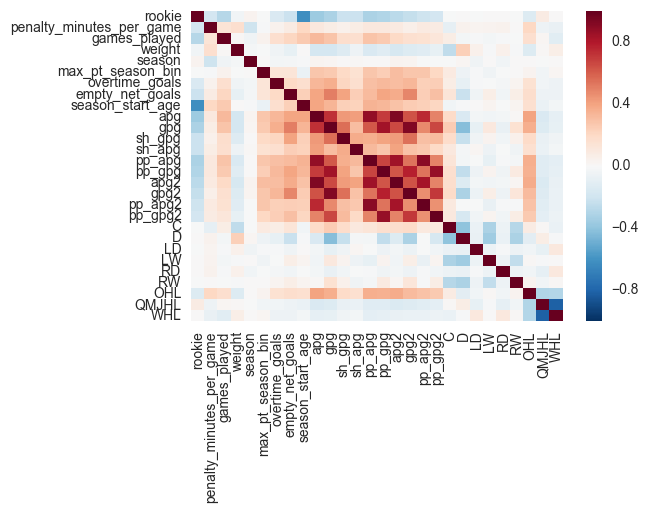

In [114]:
sns.heatmap(df_final.corr())

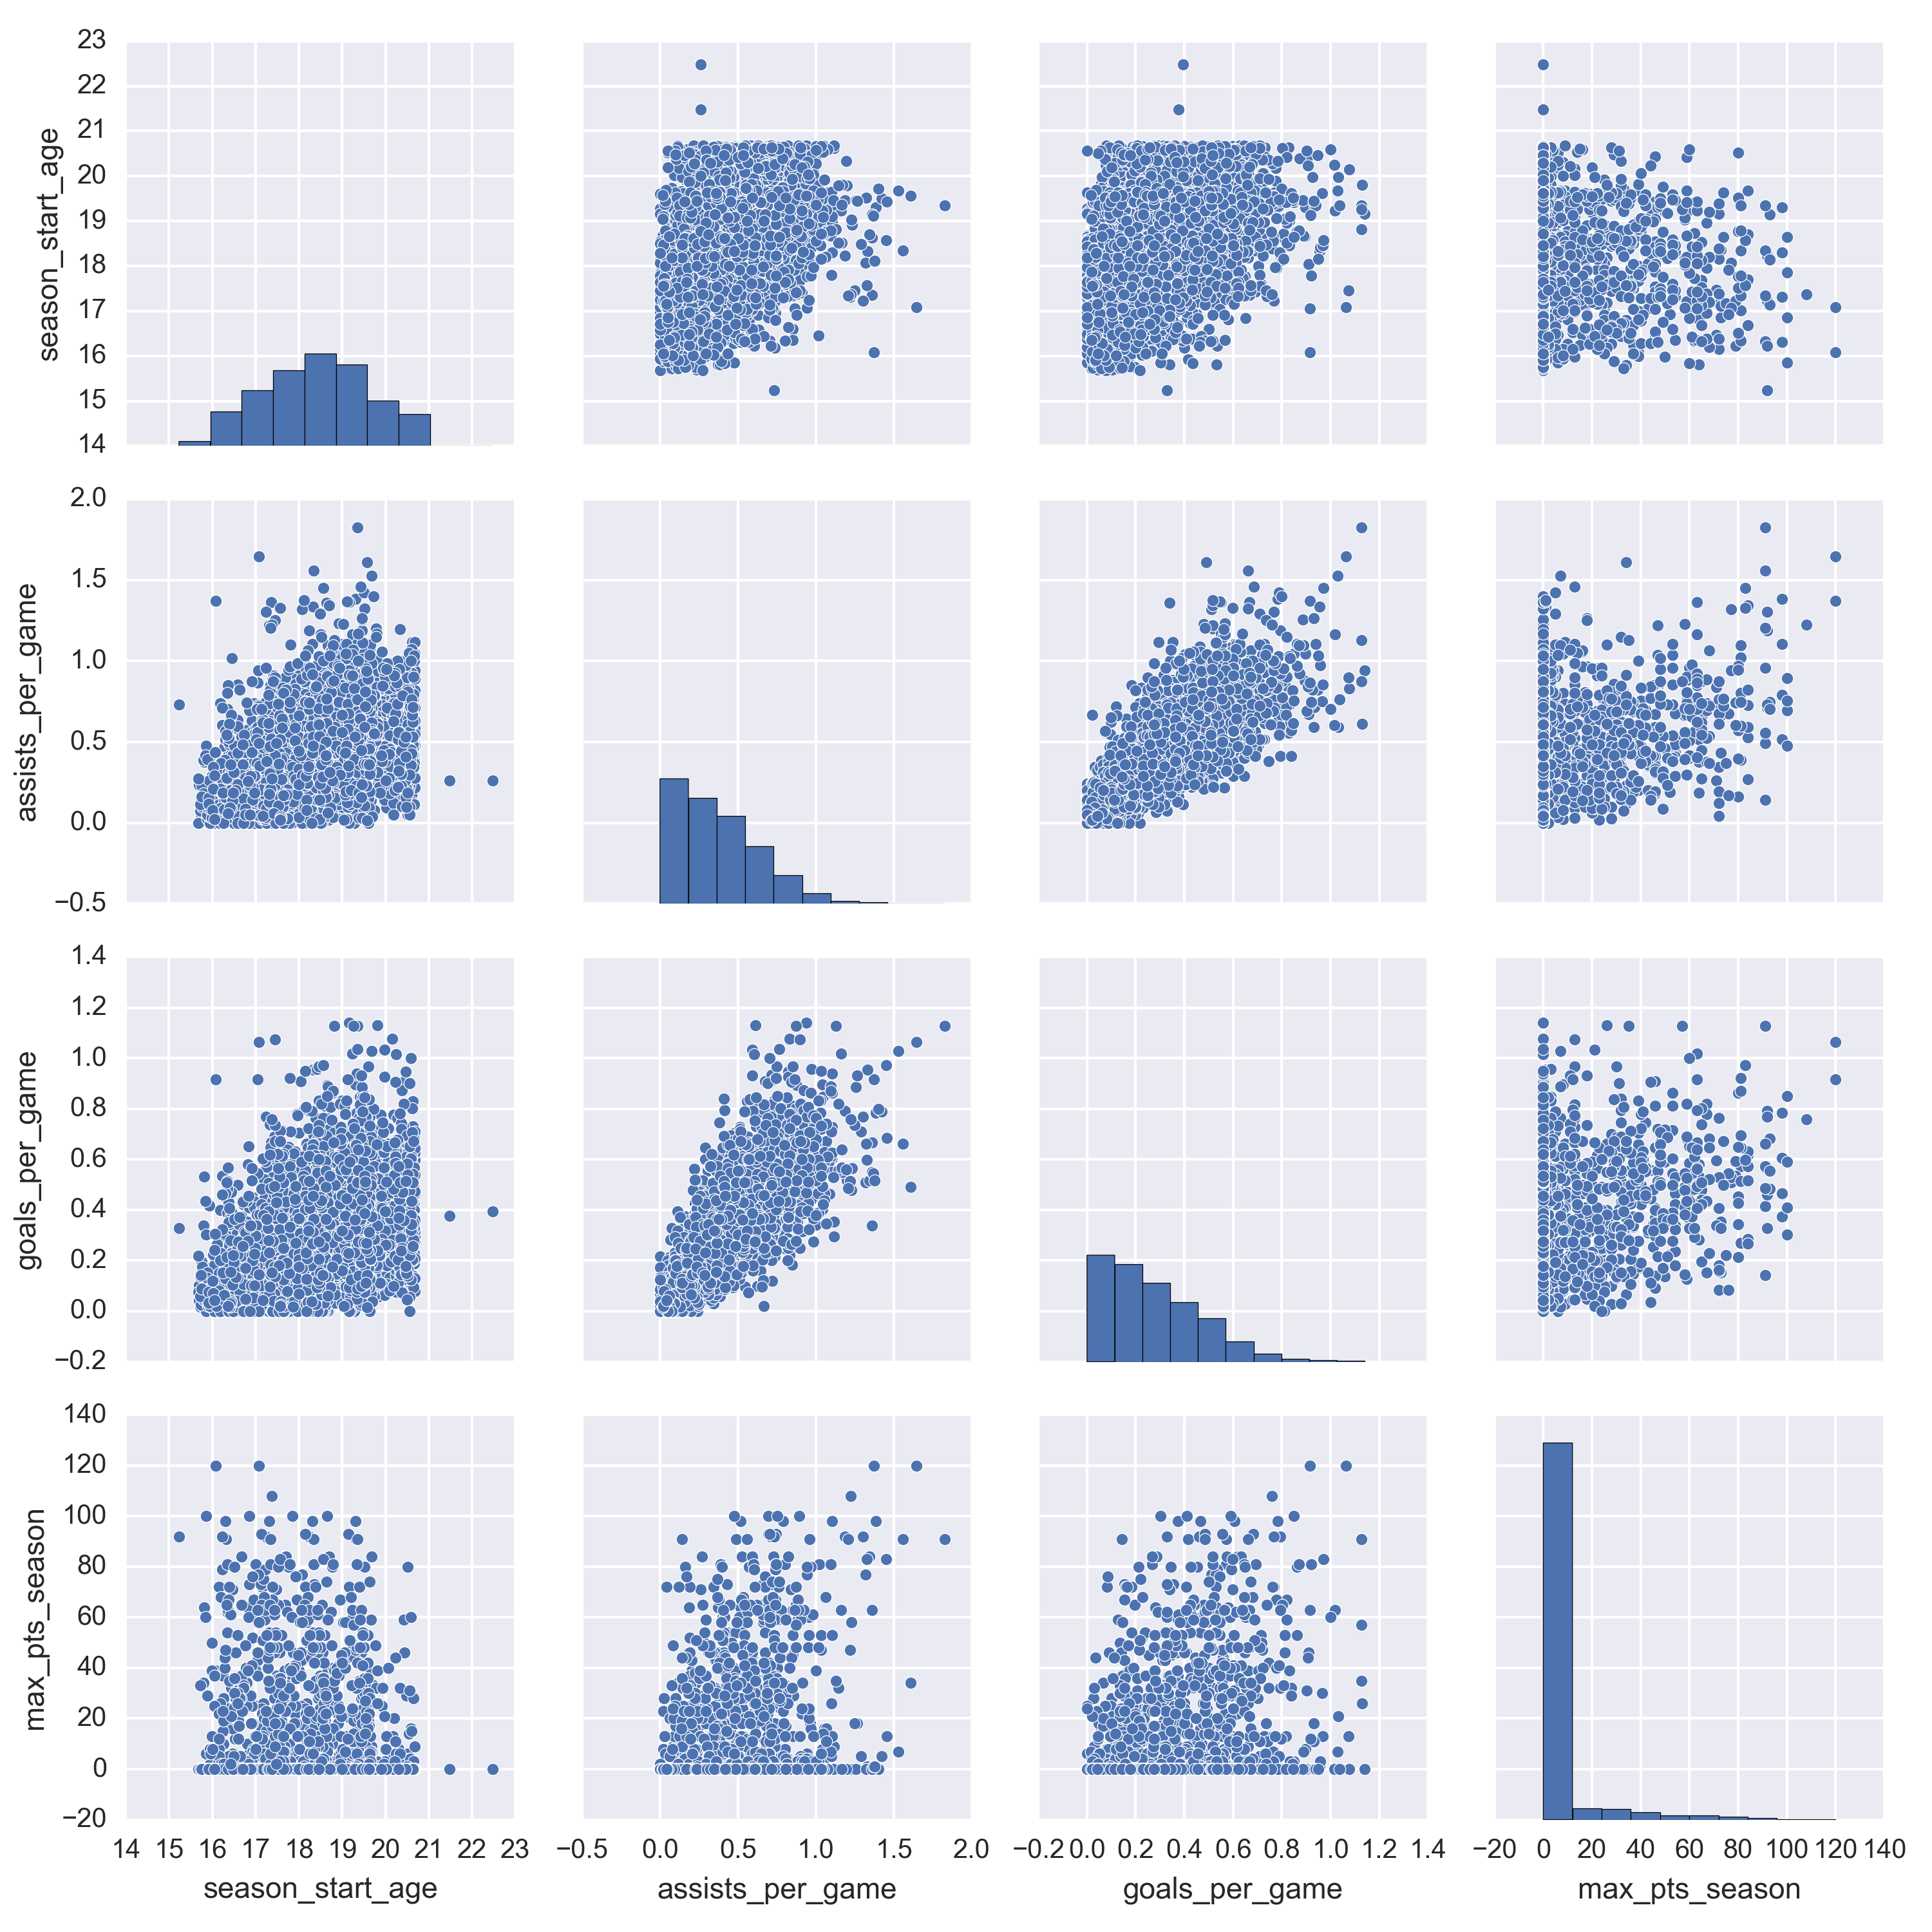

In [471]:
Image('/Users/gmaclenn/Documents/capstone-project/pairplot.png')

We can see there's quite a bit of noise in each of these features but there are some slight trends to glean from the figures.

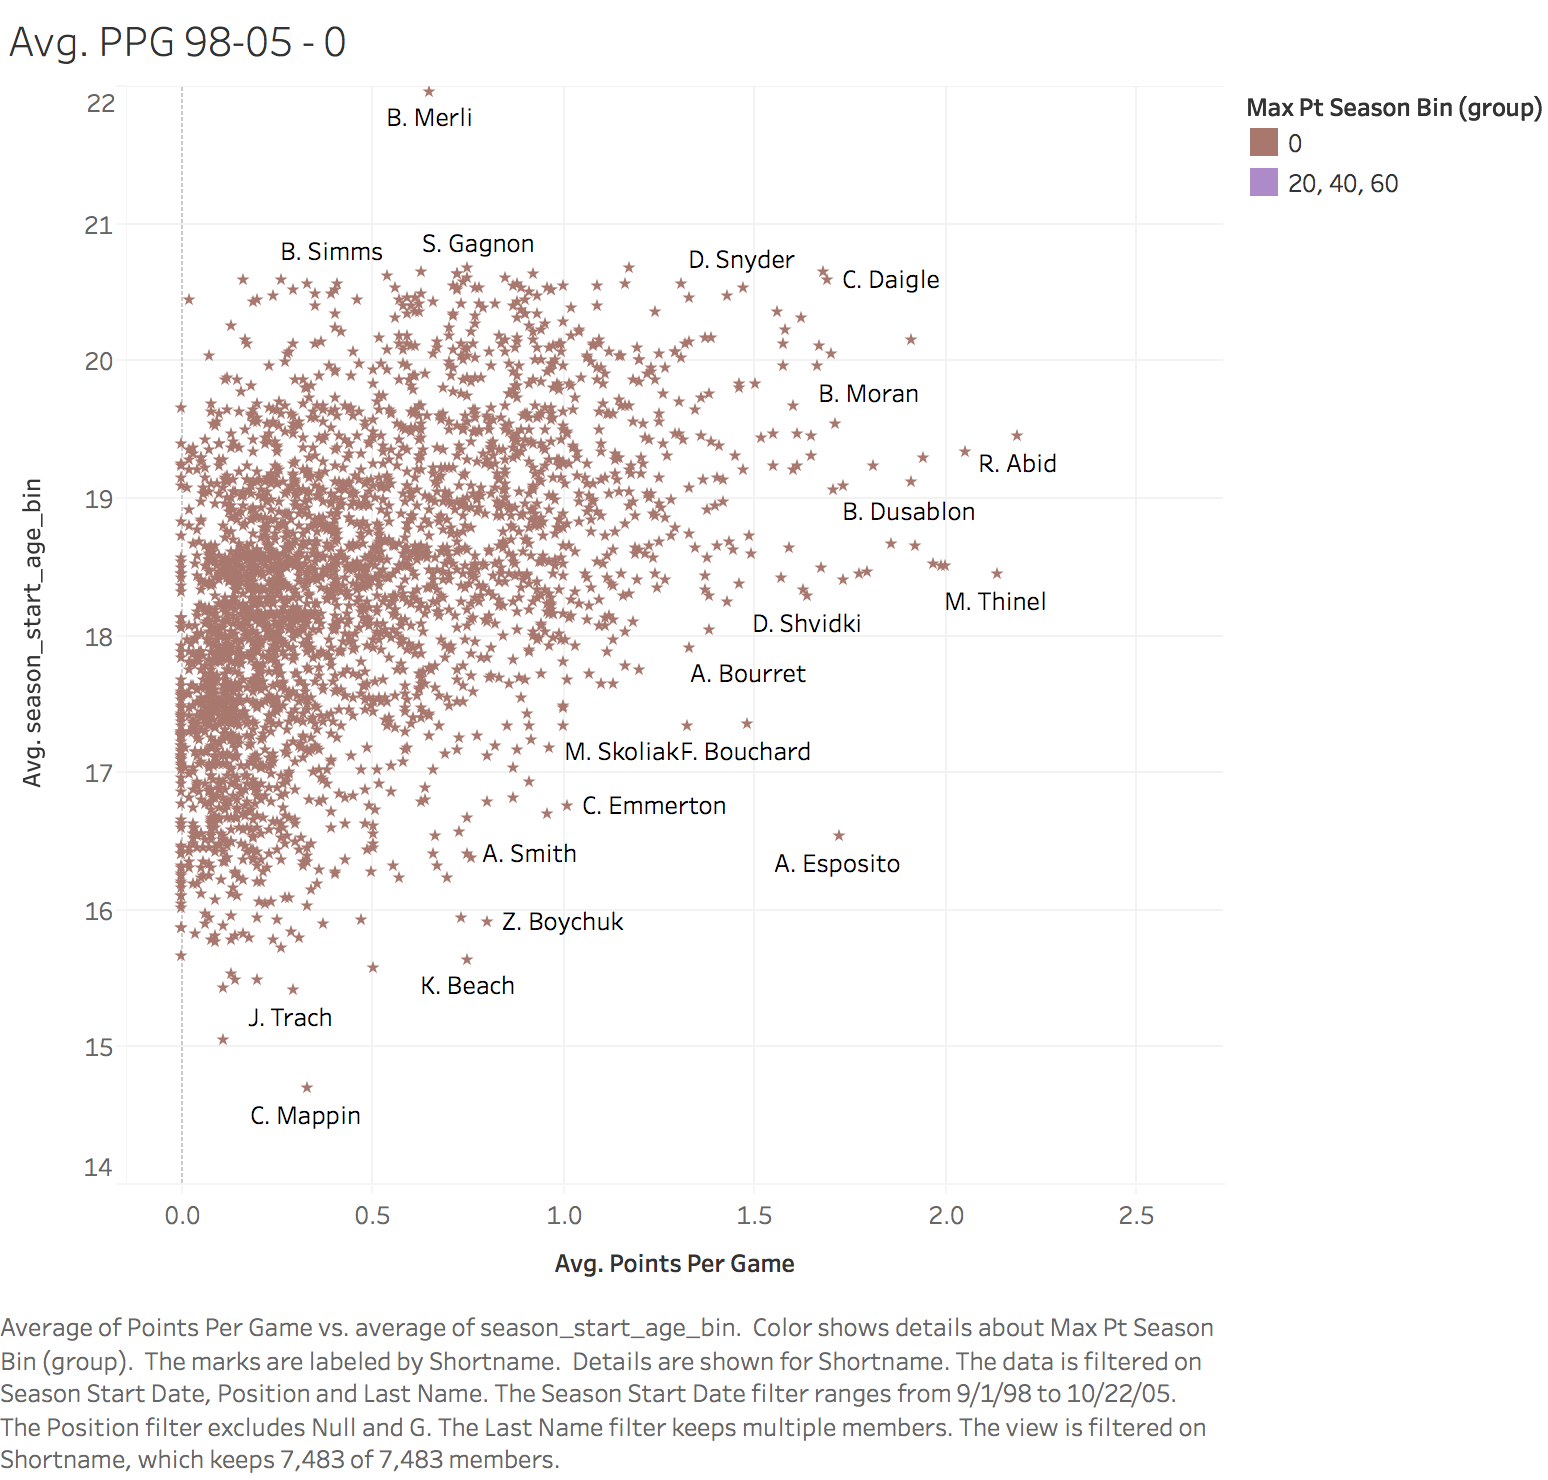

In [128]:
Image('/Users/gmaclenn/Desktop/Avg. PPG 98-05.png', height=800, width=800)

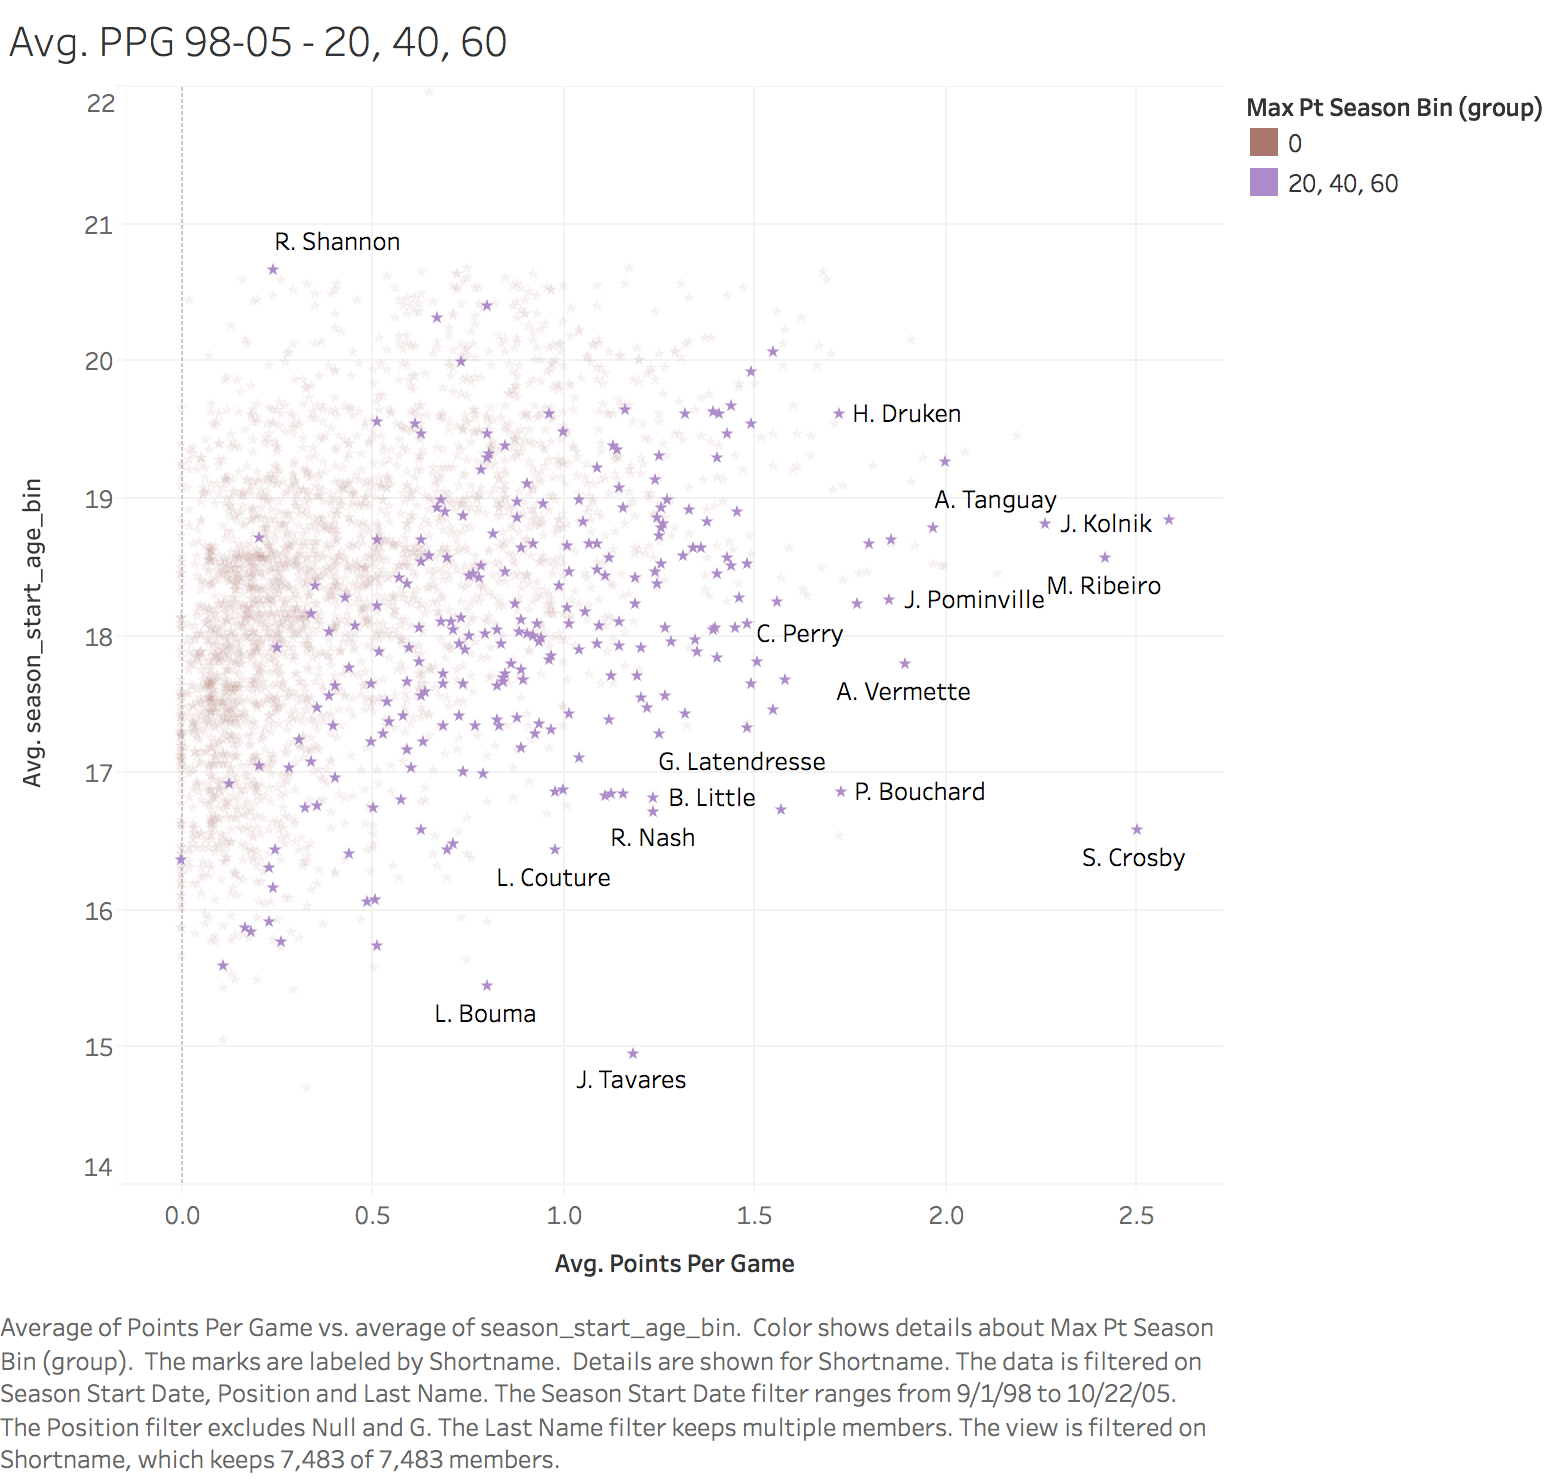

In [129]:
Image('/Users/gmaclenn/desktop/Avg. PPG 98-05_overlay.png', width=800)

### Filter by the cutoff season

In [555]:
# split by season since the newer seasons will be harder to predict

season_cutoff = 6 # not inclusive so it will cutoff at 2005

X_fin = df_final[(df_final['season'] < season_cutoff) | (df_final['season'] > 90)]
y = y[(y['season'] < season_cutoff) | (y['season'] > 90)]


# will not be able to verify but for fun
fun_final_test = df_final[(df_final['season'] > 12) & (df_final['season'] < 90)]

In [559]:
draft_eligible_17 = fun_final_test[(fun_final_test.birthdate > datetime(1997, 1, 1)) & 
                                   (fun_final_test.birthdate < datetime(1999, 9, 15))]

### Use pivot tables on the data

This will allow us to see a players full body of work and use an average of those metrics. As you can see it ends up to about 

In [570]:
X_piv = pd.pivot_table(X_fin, index='full_name', aggfunc=np.mean).drop(['season', 'max_pt_season_bin'], axis=1)
y_piv = pd.pivot_table(y, index='full_name', aggfunc=np.mean).drop(['season'], axis=1)

# for final analysis
draft_eligible_17 = pd.pivot_table(draft_eligible_17, index='full_name', aggfunc=np.mean).drop(['season', 'max_pt_season_bin'], axis=1, errors='ignore')
len(X_piv), len(y_piv), len(draft_eligible_17)

(3371, 3371, 689)

In [571]:
# reset the index and drop the full name so we can put this through
# the train test split
X_piv_r = X_piv.reset_index().drop('full_name', axis=1)
y_piv_r = y_piv.reset_index().drop('full_name', axis=1)

# for final analysis
final_test = draft_eligible_17.reset_index()
draft_eligible_17_final = draft_eligible_17.reset_index().drop('full_name', axis=1)
len(X_piv_r), len(y_piv_r), len(draft_eligible_17_final)

(3371, 3371, 689)

### Use train test split to split up the data

In [329]:
# Run if we want to create pivot tables of data

X_train, X_test, y_train, y_test = train_test_split(X_piv_r, y_piv_r, test_size=0.25, random_state=42)

In [330]:
len(X_train), len(y_train)
len(X_test), len(y_test)

(843, 843)

In [331]:
# convert to binary classifier for y_train & y_test
def convert_to_binary(x):
    if x > 0:
        return 1
    else:
        return 0

y_train_binary = y_train.max_pt_season_bin.apply(convert_to_binary)
y_test_binary = y_test.max_pt_season_bin.apply(convert_to_binary)

### Training Set Observations:

* Trained on WHL, QMJHL, OHL seasons 98-2005:
* Average Age @ Season Start: 18.29, Min: 15.29 Max: 20.9


In [603]:
X_piv.describe()

C            D           LD           LW          OHL  \
count  3371.000000  3371.000000  3371.000000  3371.000000  3371.000000   
mean      0.258568     0.313987     0.009320     0.219366     0.125210   
std       0.421204     0.454569     0.081788     0.398126     0.330043   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.500000     1.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             QMJHL           RD           RW          WHL          apg  \
count  3371.000000  3371.000000  3371.000000  3371.000000  3371.000000   
mean      0.423148     0.006526     0.184248     0.451641     0.302234   
std       0.493238     0.073971     0.376494     0.496201     0.243501   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.106731   
50%       0.000000     0.000000     0.000000     0.000000     0.242604   
75%       1.000000     0.000000     0.000000     1.000000     0.456116   
max       1.000000     1.000000     1.000000     1.000000     1.530200   

          ...       penalty_minutes_per_game       pp_apg      pp_apg2  \
count     ...                    3371.000000  3371.000000  3371.000000   
mean      ...                       0.366445     0.106115     0.028365   
std       ...                       0.656820     0.118654     0.050202   
min       ...                       0.000000     0.000000     0.000000   
25%       ...                       0.000000     0.006803     0.000111   
50%       ...                       0.000000     0.062127     0.005569   
75%       ...                       0.520000     0.170931     0.034125   
max       ...                       6.540000     0.717195     0.519717   

            pp_gpg      pp_gpg2       rookie  season_start_age       sh_apg  \
count  3371.000000  3371.000000  3371.000000       3371.000000  3371.000000   
mean      0.057604     0.009103     0.386671         18.296520     0.006993   
std       0.067864     0.017171     0.370990          1.026991     0.014782   
min       0.000000     0.000000     0.000000         15.298630     0.000000   
25%       0.000000     0.000000     0.000000         17.586301     0.000000   
50%       0.032258     0.001675     0.333333         18.345205     0.000000   
75%       0.093448     0.010696     0.500000         19.011644     0.009914   
max       0.471429     0.222245     1.000000         20.976712     0.500000   

            sh_gpg       weight  
count  3371.000000  3371.000000  
mean      0.008022   193.737309  
std       0.015735    15.411344  
min       0.000000   141.000000  
25%       0.000000   184.000000  
50%       0.000000   193.000000  
75%       0.010192   204.000000  
max       0.206349   265.000000  

[8 rows x 26 columns]

### Model Selection

Models reviewed: Decision Tree, Random Forest, Logistic Regression, SVM, AdaBoost, KNN

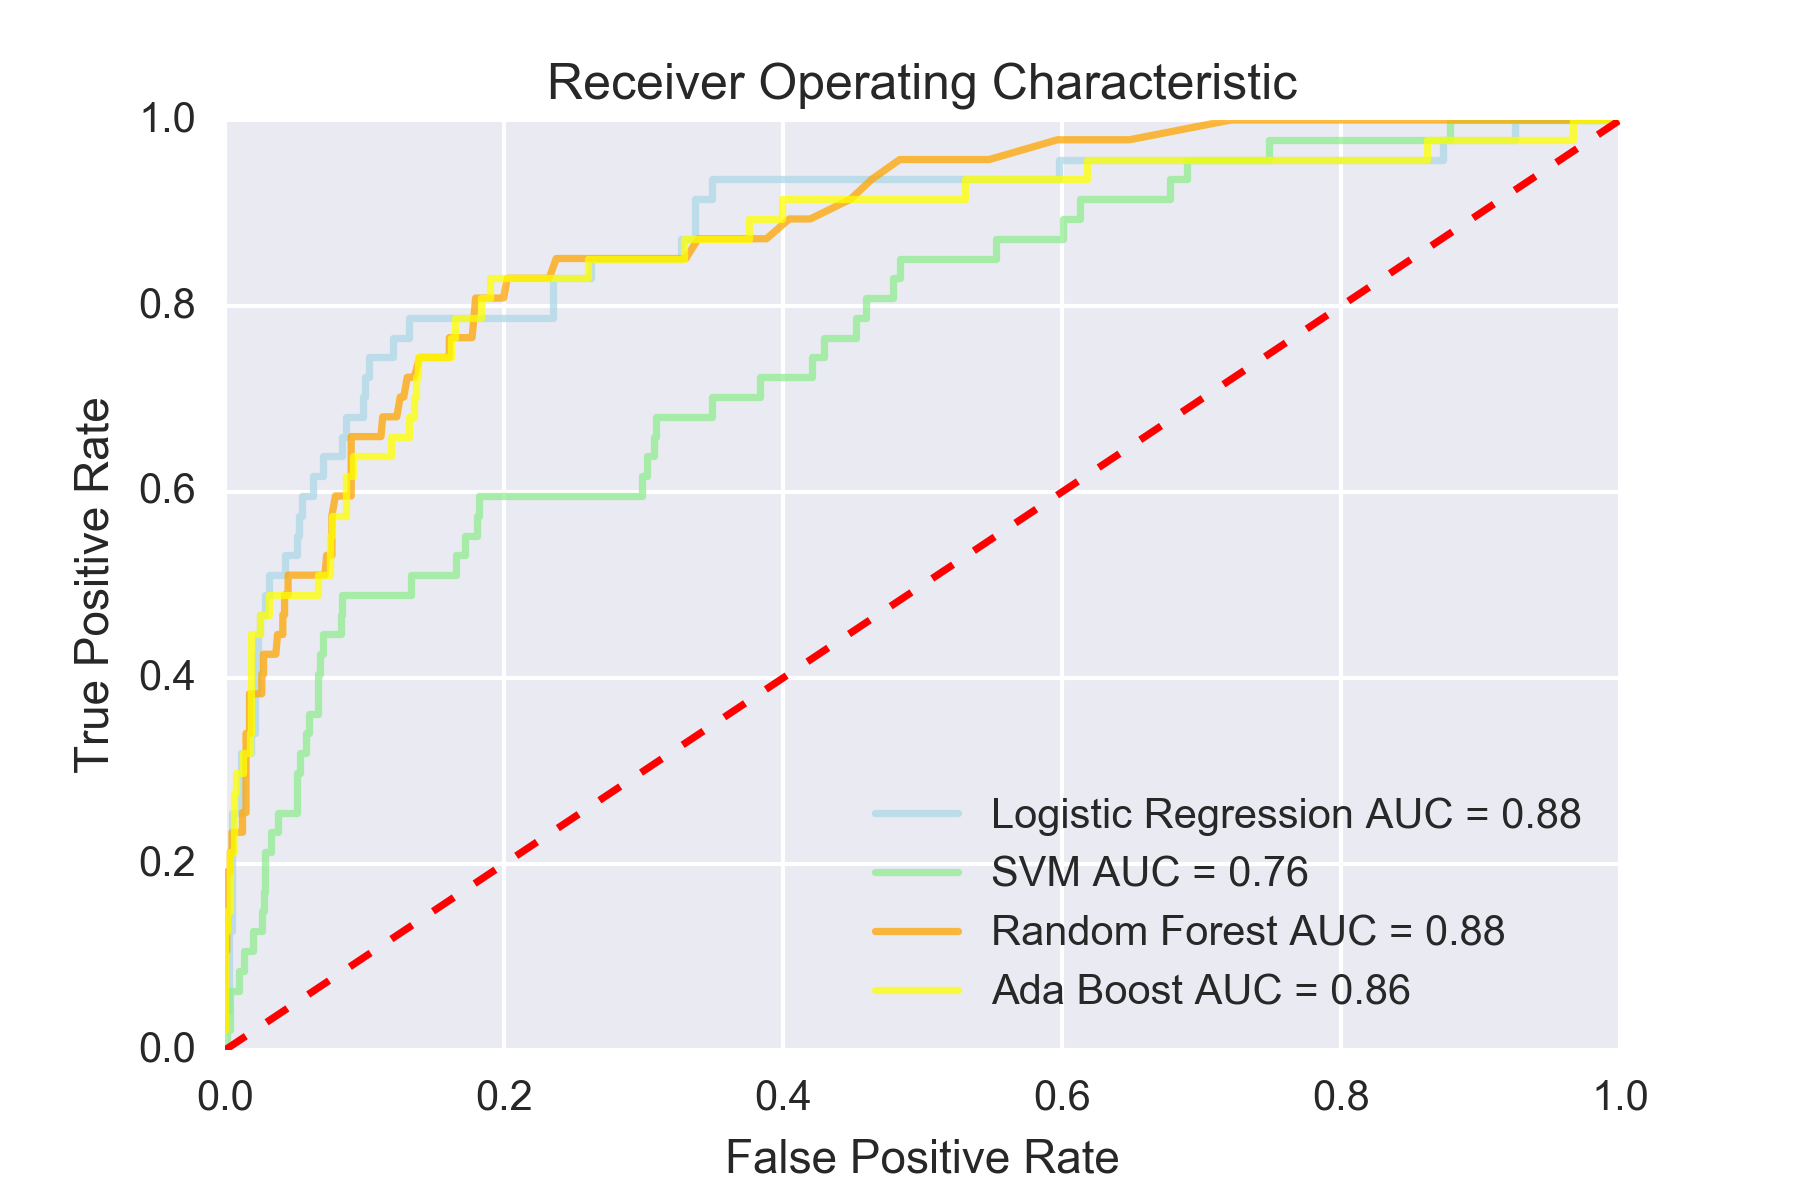

In [470]:
Image('/Users/gmaclenn/Documents/capstone-project/ROC_curve.png', width=800)

### Logistic Regression

In [641]:
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

logit = LogisticRegression(penalty='l2', C=0.001, class_weight='balanced')

model_a = logit.fit(X_train, np.ravel(y_train_binary))
y_pred = model_a.predict(X_test)


confmat_logit = confusion_matrix(y_true=y_test_binary, y_pred=y_pred)
print "\t\t\t Logistic Regression Performance \n"
print classification_report(y_test_binary, y_pred), '\n'

confusion_matrix_logit = pd.DataFrame(confmat_logit, 
                                    index=['Actual MPS < 20', 'Actual MPS > 20'],
                                    columns=['Predicted MPS < 20', 'Predicted MPS > 20'])

print confusion_matrix_logit, '\n'

			 Logistic Regression Performance 

             precision    recall  f1-score   support

          0       0.99      0.72      0.83       796
          1       0.16      0.87      0.26        47

avg / total       0.94      0.73      0.80       843


                 Predicted MPS < 20  Predicted MPS > 20
Actual MPS < 20                 573                 223
Actual MPS > 20                   6                  41 



### Logistic Regression GS

In [642]:
# pipeline for GS
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = {'clf__C': param_range, 
              'clf__penalty': ['l1', 'l2']}

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, np.ravel(y_train_binary))
print(gs.best_score_)
print(gs.best_params_)

0.928006329114
{'clf__penalty': 'l1', 'clf__C': 0.1}


Grid searched with Logistic Regression and even with a number of different scoring metrics, AUC, Accuracy, F1, F1_micro, F1_macro, the results were still very noisy without a lot of separation between the palyers we wanted to predict having success in the NHL.

### SVM

In [632]:
from sklearn.svm import SVC

X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

svm = SVC(probability=True, C=10, kernel='rbf', degree=3)


model_svm = svm.fit(X_train, np.ravel(y_train_binary))
y_pred_svm = model_svm.predict(X_test)

confmat_svm = confusion_matrix(y_true=y_test_binary, y_pred=y_pred_svm)

print "\t\t\t SVM Performance \n"
print classification_report(y_test_binary, y_pred_svm), '\n'

confusion_matrix_svm = pd.DataFrame(confmat_svm, 
                                    index=['Actual MPS < 20', 'Actual MPS > 20'],
                                    columns=['Predicted MPS < 20', 'Predicted MPS > 20'])

print confusion_matrix_svm, '\n'

			 SVM Performance 

             precision    recall  f1-score   support

          0       0.96      0.97      0.97       796
          1       0.42      0.32      0.36        47

avg / total       0.93      0.94      0.93       843


                 Predicted MPS < 20  Predicted MPS > 20
Actual MPS < 20                 775                  21
Actual MPS > 20                  32                  15 



In [361]:
# Example code for a model and a set of grid-search parameters
rfc = RandomForestClassifier()

parameters = [{"n_estimators": [250, 500, 1000],
              "max_depth": [3, 5, 7, 9, 11, None],
              "max_features": np.arange(3,27),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}]
 
# Returns the best configuration for a model using cross validation
# and grid search
def best_config(model, parameters, train_instances, judgements):
    clf = GridSearchCV(model, parameters, cv=5,
                       scoring="f1_macro", verbose=5, n_jobs=4)
    clf.fit(train_instances, judgements)
    best_estimator = clf.best_estimator_
 
    return [str(clf.best_params_), clf.best_score_,
            best_estimator]

best_config(rfc, parameters, X_train, np.ravel(y_train_binary))

# Ada Boost

In [612]:
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=8,
                              random_state=0)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=1000, 
                         learning_rate=1.0,
                         random_state=0)

In [613]:
tree = tree.fit(X_train, np.ravel(y_train_binary))
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = f1_score(y_train_binary, y_train_pred)
tree_test = f1_score(y_test_binary, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, np.ravel(y_train_binary))
y_train_pred = ada.predict(X_train)
y_test_ada = ada.predict(X_test)

ada_train = f1_score(np.ravel(y_train_binary), y_train_pred) 
ada_test = f1_score(np.ravel(y_test_binary), y_test_ada) 

print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.765/0.310
AdaBoost train/test accuracies 1.000/0.300


In [625]:
# Check the score on the 

confmat_tree = confusion_matrix(y_true=y_test_binary, y_pred=y_test_tree)
confmat_ada = confusion_matrix(y_true=y_test_binary, y_pred=y_test_ada)

print "\t\t\t Decision Tree Performance"
print classification_report(y_test_binary, y_test_tree)
# put the confusion matrix in a dataframe
confusion_matrix_tree = pd.DataFrame(confmat_tree, 
                                    index=['Actual MPS < 20', 'Actual MPS > 20'],
                                    columns=['Predicted MPS < 20', 'Predicted MPS > 20'])
print confusion_matrix_tree, '\n\n\n'

print "\t\t\t Ada Boost Performance"
print classification_report(y_test_binary, y_test_ada)
confusion_matrix_ada = pd.DataFrame(confmat_ada, 
                                    index=['Actual MPS < 20', 'Actual MPS > 20'],
                                    columns=['Predicted MPS < 20', 'Predicted MPS > 20'])

print confusion_matrix_ada, '\n'

			 Decision Tree Performance
             precision    recall  f1-score   support

          0       0.96      0.97      0.96       796
          1       0.33      0.26      0.29        47

avg / total       0.92      0.93      0.93       843

                 Predicted MPS < 20  Predicted MPS > 20
Actual MPS < 20                 772                  24
Actual MPS > 20                  35                  12 



			 Ada Boost Performance
             precision    recall  f1-score   support

          0       0.95      0.99      0.97       796
          1       0.69      0.19      0.30        47

avg / total       0.94      0.95      0.94       843

                 Predicted MPS < 20  Predicted MPS > 20
Actual MPS < 20                 792                   4
Actual MPS > 20                  38                   9 



Why Random Forests:

Random Forests method is an ensemble method, which means that it generates multiple models which learn and make predictions independently. These predictions are then combined into a single prediction, which in typically cancels out the weaknesses of each individual model. Random forests specifically uses decision trees as the base model. Decision trees begin at a "tree root" and split the data on features that result in the largest information gain. The process stops when all child nodes contain only one of the two classes.

# Best Grid Searched Model

In [333]:
# define the model parameters
rfr_gs = RandomForestClassifier(max_features=10, n_estimators=500, bootstrap=False, 
                                     criterion='entropy', max_depth=None, n_jobs=4)

# train the model
rfr_gs_model = rfr_gs.fit(X_train, np.ravel(y_train_binary))

# predict the values on the test set
y_pred_rfr = rfr_gs_model.predict(X_test)

In [617]:
# construct the confusion matrix
confmat_rfc = confusion_matrix(y_true=y_test_binary, y_pred=y_pred_rfr)

# put the confusion matrix in a dataframe
confusion_matrix_rfc = pd.DataFrame(confmat_rfc, 
                                    index=['Actual MPS < 20', 'Actual MPS > 20'],
                                    columns=['Predicted MPS < 20', 'Predicted MPS > 20'])


print '\t Random Forest Classifier Performance'
print "\t *MPS - Max points scored in an NHL season* \n"
print confusion_matrix_rfc, '\n\n'
print classification_report(y_test_binary, y_pred_rfr, target_names=["MPS < 20", 'MPS > 20'])


	 Random Forest Classifier Performance
	 *MPS - Max points scored in an NHL season* 

                 Predicted MPS < 20  Predicted MPS > 20
Actual MPS < 20                 784                  12
Actual MPS > 20                  33                  14 


             precision    recall  f1-score   support

   MPS < 20       0.96      0.98      0.97       796
   MPS > 20       0.54      0.30      0.38        47

avg / total       0.94      0.95      0.94       843



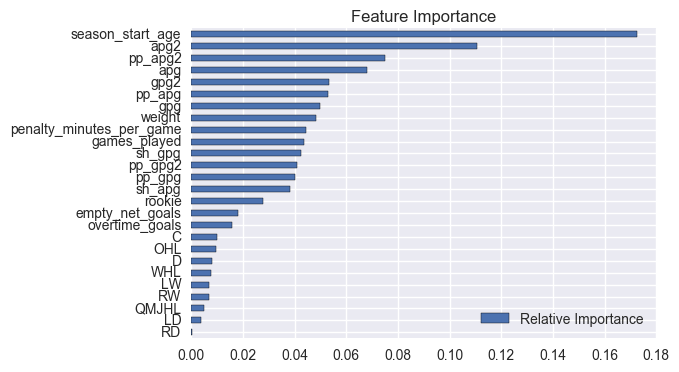

In [417]:
feature_importance = pd.DataFrame(rfr_gs_model.feature_importances_, index=X_piv_r.columns).sort_values(by=0, ascending=True)
feature_importance = feature_importance.rename(columns={0:'Relative Importance'})
feature_importance.plot(kind='barh')
plt.title('Feature Importance')

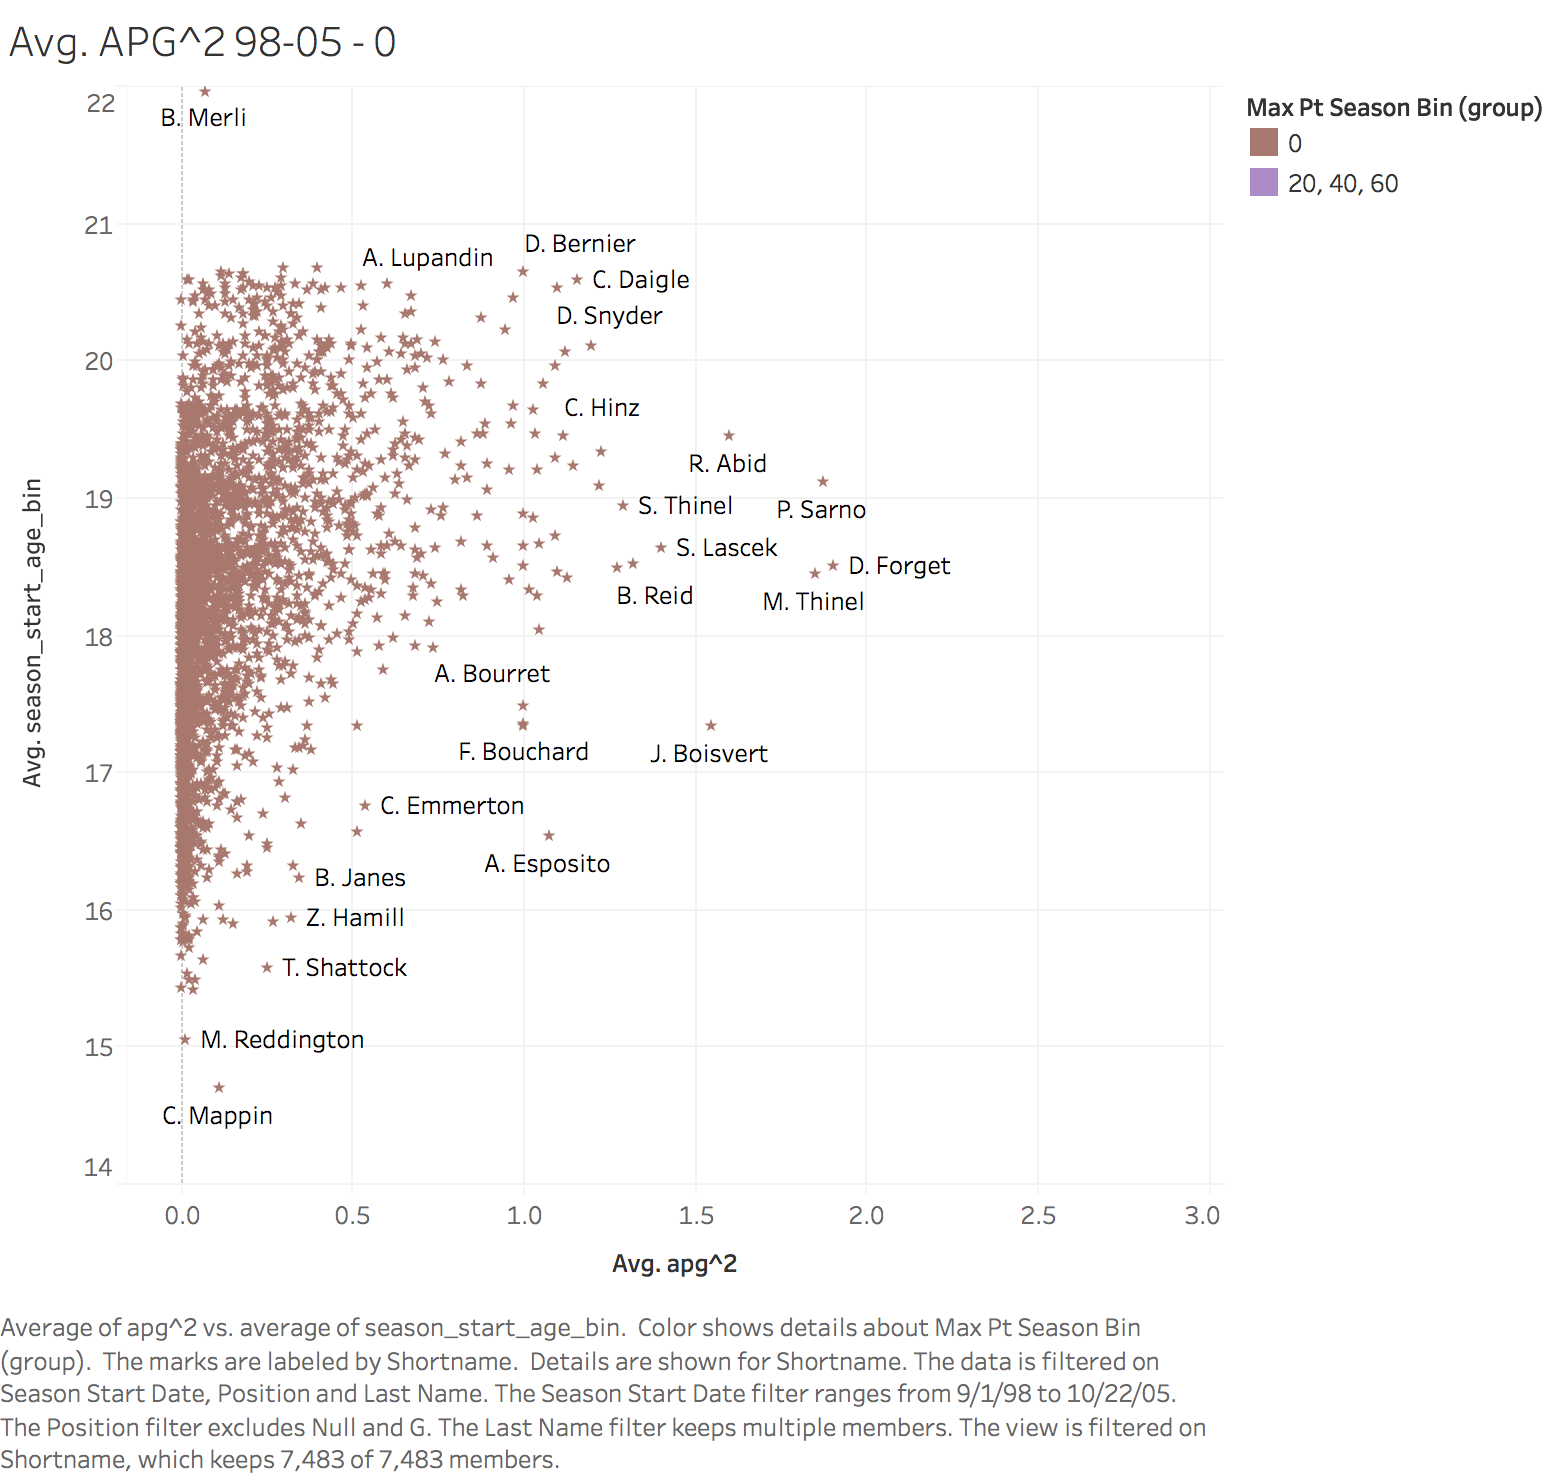

In [131]:
Image('/Users/gmaclenn/Desktop/Avg. APG^2 98-05.png', width=800)

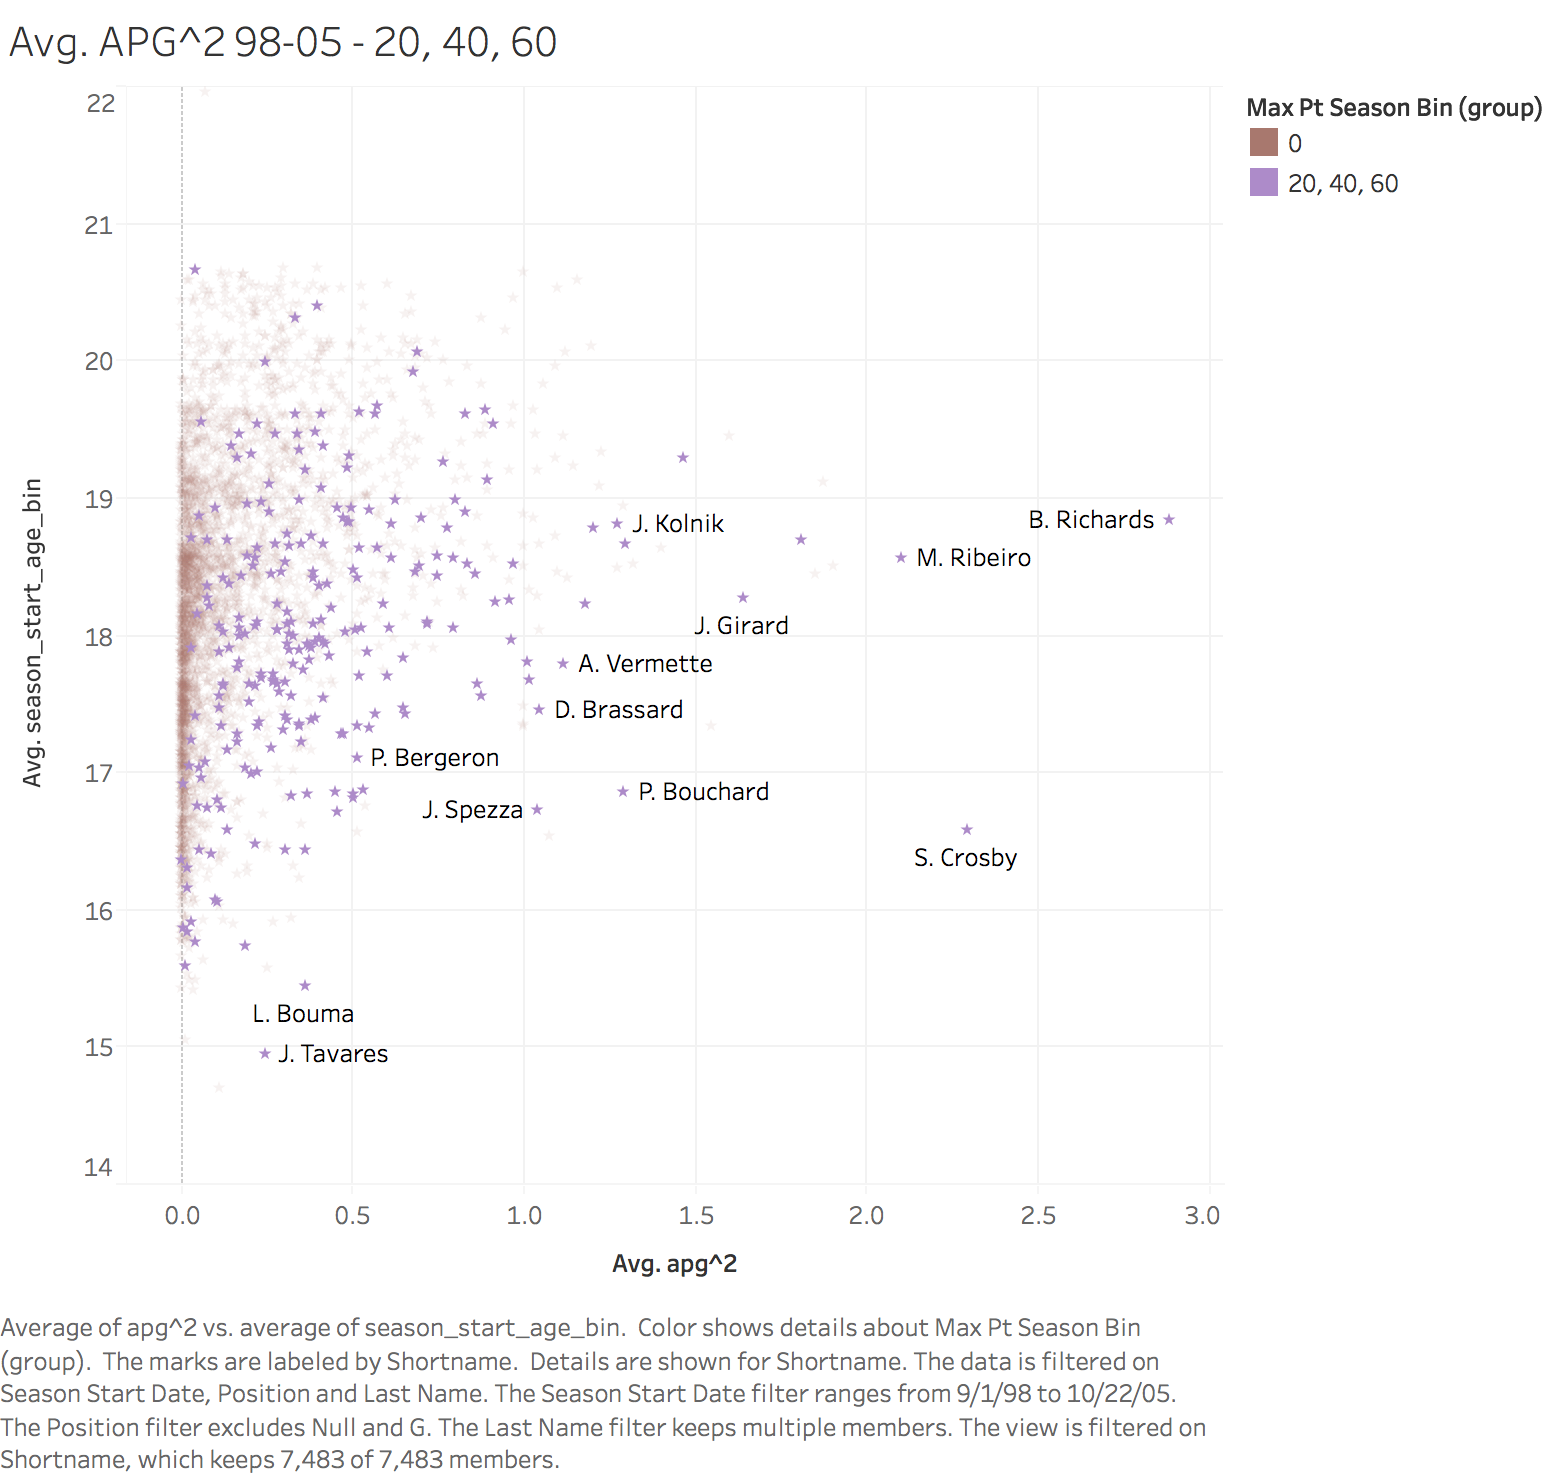

In [132]:
Image('/Users/gmaclenn/Desktop/Avg. APG^2 98-05_overlay.png', width=800)

# Results

In our final model, the most important features were season start age, assists per game squared and power-play asissts per game squared. The ADA boost method also provided fairly good results with 69% precision, however it provided better precision at the cost of recall and the overall f1 score versus the Random Forests Classifier. The results hammer home a few important points. The first is that high level production at the Major Junior level still does not guarantee a baseline level of success at the NHL. Even some of the best performers at a young age fail to make even a modest impact at the next level. Much of this has to do with the fact that there is so much physical development that goes on in between the age 15-18 seasons and a player in their point scoring prime in the NHL at age 24-26.

Finally, I think this study lends further creedence to the idea that there should be an increased look at advanced analytics being used in the Junior league levels. The NHL has started to embrace this with a few teams hiring members from the hockey analytics community, most recently & notably WAR ON ICE co-founder Sam Ventura was hired to the Pittsburgh Penguins to head their analytics staff in 2015[14]. There are a few people who are doing some interesting work to pull additional statistics out of these games beyond the popular corsi and fenwick. For instance, Ryan Stimson's Expected Primary Points would be a great stat to add into the CHL model[15].

### ROC Curve Code

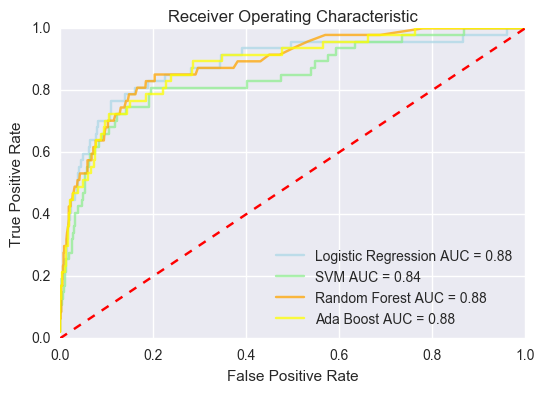

In [639]:
# train models
model = logit.fit(X_train, np.ravel(y_train_binary))
model_svm = svm.fit(X_train, np.ravel(y_train_binary))
rfr_gs_model = rfr_gs.fit(X_train, np.ravel(y_train_binary))
ada_model = ada.fit(X_train, np.ravel(y_train_binary))

# pull together roc curve
probs = model.predict_proba(X_test)
y_preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test_binary, y_preds)
roc_auc = auc(fpr, tpr)

probs_svm = model_svm.predict_proba(X_test)
preds_svm = probs_svm[:,1]
fpr_svm, tpr_svm, threshold = roc_curve(y_test_binary, preds_svm)
svm_auc = auc(fpr_svm, tpr_svm)

probs_rfr = rfr_gs_model.predict_proba(X_test)
preds_rfr = probs_rfr[:,1]
fpr_rfr, tpr_rfr, threshold = roc_curve(y_test_binary, preds_rfr)
rfr_auc = auc(fpr_rfr, tpr_rfr)

probs_ada = ada.predict_proba(X_test)
preds_ada = probs_ada[:,1]
fpr_ada, tpr_ada, threshold = roc_curve(y_test_binary, preds_ada)
ada_auc = auc(fpr_ada, tpr_ada)

# plot values
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'lightblue', alpha =0.75, label = 'Logistic Regression AUC = %0.2f' % roc_auc)
plt.plot(fpr_svm, tpr_svm, 'lightgreen', alpha =0.75, label = 'SVM AUC = %0.2f' % svm_auc)
plt.plot(fpr_rfr, tpr_rfr, 'orange', alpha =0.75, label = 'Random Forest AUC = %0.2f' % rfr_auc)
plt.plot(fpr_ada, tpr_ada, 'yellow', alpha =0.75, label = 'Ada Boost AUC = %0.2f' % ada_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.savefig('/Users/gmaclenn/Documents/capstone-project/ROC_curve.png', dpi=300)
plt.show()

### Examining Classes from 13-16 Seasons using the Random Forests Classifier

In [591]:
draft_17_preds = rfr_gs_model.predict(draft_eligible_17_final)
draft_eligible_predictions = pd.concat([final_test, pd.DataFrame(draft_17_preds)], axis=1)
draft_eligible_predictions[['full_name', 'season_start_age','apg2','gpg2', 0]].sort_values(0,ascending=False)
draft_eligible_predictions.to_csv('/Users/gmaclenn/Documents/capstone-project/Data Notebooks/draft_eligible_predictions.csv')
draft_eligible_predictions

full_name    C    D   LD   LW  OHL  QMJHL   RD   RW  WHL ...  \
0             Aaron Boyd  0.0  0.0  0.0  1.0  0.0    1.0  0.0  0.0  0.0 ...   
1            Aaron Hyman  0.0  1.0  0.0  0.0  0.0    1.0  0.0  0.0  0.0 ...   
2           Aaron Luchuk  1.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  1.0 ...   
3            Adam  Musil  1.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  0.0 ...   
4              Adam Berg  0.0  0.0  0.0  1.0  0.0    1.0  0.0  0.0  0.0 ...   
5         Adam Craievich  0.0  0.0  0.0  0.0  0.0    0.0  0.0  1.0  1.0 ...   
6         Adam Kozlowski  0.0  0.0  0.0  1.0  0.0    0.0  0.0  0.0  1.0 ...   
7          Adam Laishram  1.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  1.0 ...   
8             Adam Marsh  0.0  0.0  0.0  1.0  1.0    0.0  0.0  0.0  0.0 ...   
9         Adam Mascherin  0.0  0.0  0.0  1.0  0.0    0.0  0.0  0.0  1.0 ...   
10          Adam McPhail  0.0  0.0  0.0  0.0  0.0    0.0  0.0  1.0  1.0 ...   
11          Adam Timleck  0.0  0.0  0.0  0.0  0.0    0.0  0.0  1.0  1.0 ...   
12      Adrian Carbonara  0.0  0.0  0.0  0.0  0.0    0.0  0.0  1.0  1.0 ...   
13     Alan Lyszczarczyk  1.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  1.0 ...   
14             Alec Baer  1.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  0.0 ...   
15            Aleks Rapp  0.0  0.0  0.0  0.0  0.0    0.0  0.0  1.0  1.0 ...   
16     Alex Barré-Boulet  1.0  0.0  0.0  0.0  1.0    0.0  0.0  0.0  0.0 ...   
17            Alex Black  0.0  1.0  0.0  0.0  0.0    0.0  0.0  0.0  1.0 ...   
18        Alex DeBrincat  0.0  0.0  0.0  0.0  0.0    0.0  0.0  1.0  1.0 ...   
19         Alex Di Carlo  0.0  1.0  0.0  0.0  0.0    0.0  0.0  0.0  1.0 ...   
20           Alex Dostie  1.0  0.0  0.0  0.0  1.0    0.0  0.0  0.0  0.0 ...   
21        Alex Overhardt  1.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  0.0 ...   
22    Alexander Nylander  0.0  0.0  0.0  1.0  0.0    0.0  0.0  0.0  1.0 ...   
23        Alexander True  1.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  0.0 ...   
24      Alexandre Fortin  0.0  0.0  0.0  1.0  1.0    0.0  0.0  0.0  0.0 ...   
25     Anatolii Elizarov  0.0  1.0  0.0  0.0  0.0    1.0  0.0  0.0  0.0 ...   
26          Andrew Burns  0.0  1.0  0.0  0.0  0.0    0.0  0.0  0.0  1.0 ...   
27          Andrew Fyten  0.0  0.0  0.0  0.0  0.0    1.0  0.0  1.0  0.0 ...   
28           Andrew Koep  0.5  0.0  0.0  0.5  0.0    1.0  0.0  0.0  0.0 ...   
29   Anthony Beauvillier  1.0  0.0  0.0  0.0  1.0    0.0  0.0  0.0  0.0 ...   
..                   ...  ...  ...  ...  ...  ...    ...  ...  ...  ... ...   
659          Tyler Rollo  0.0  0.0  0.0  1.0  0.0    0.0  0.0  0.0  1.0 ...   
660            Tyler Soy  1.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  0.0 ...   
661    Tyler Steenbergen  1.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  0.0 ...   
662       Tyler Thompson  0.0  0.0  0.0  0.0  0.0    1.0  0.0  1.0  0.0 ...   
663      Tyson Gruninger  0.0  0.0  0.0  0.5  0.0    1.0  0.0  0.5  0.0 ...   
664       Tyson Helgesen  0.0  1.0  0.0  0.0  0.0    1.0  0.0  0.0  0.0 ...   
665         Victor  Mete  0.0  1.0  0.0  0.0  0.0    0.0  0.0  0.0  1.0 ...   
666      Vili Saarijarvi  0.0  1.0  0.0  0.0  0.0    0.0  0.0  0.0  1.0 ...   
667      Vince Loschiavo  1.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  0.0 ...   
668      Vitalii Abramov  0.0  0.0  0.0  0.0  1.0    0.0  0.0  1.0  0.0 ...   
669     Vladimir Bobylev  1.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  0.0 ...   
670   Vladimir Kuznetsov  0.0  0.0  0.0  0.0  1.0    0.0  0.0  1.0  0.0 ...   
671      Vladislav Lukin  0.0  0.0  0.0  0.0  0.0    1.0  0.0  1.0  0.0 ...   
672        Vojtech Budik  0.0  1.0  0.0  0.0  0.0    1.0  0.0  0.0  0.0 ...   
673          Will Bitten  0.5  0.0  0.0  0.0  0.0    0.0  0.0  0.5  1.0 ...   
674      William Lochead  0.0  1.0  0.0  0.0  0.0    0.0  0.0  0.0  1.0 ...   
675      Wyatt Sloboshan  1.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  0.0 ...   
676         Yakov Trenin  0.5  0.0  0.0  0.5  1.0    0.0  0.0  0.0  0.0 ...   
677         Yan Khomenko  0.0  0.0  0.0  0.0  0.0    1.0  0.0  1.

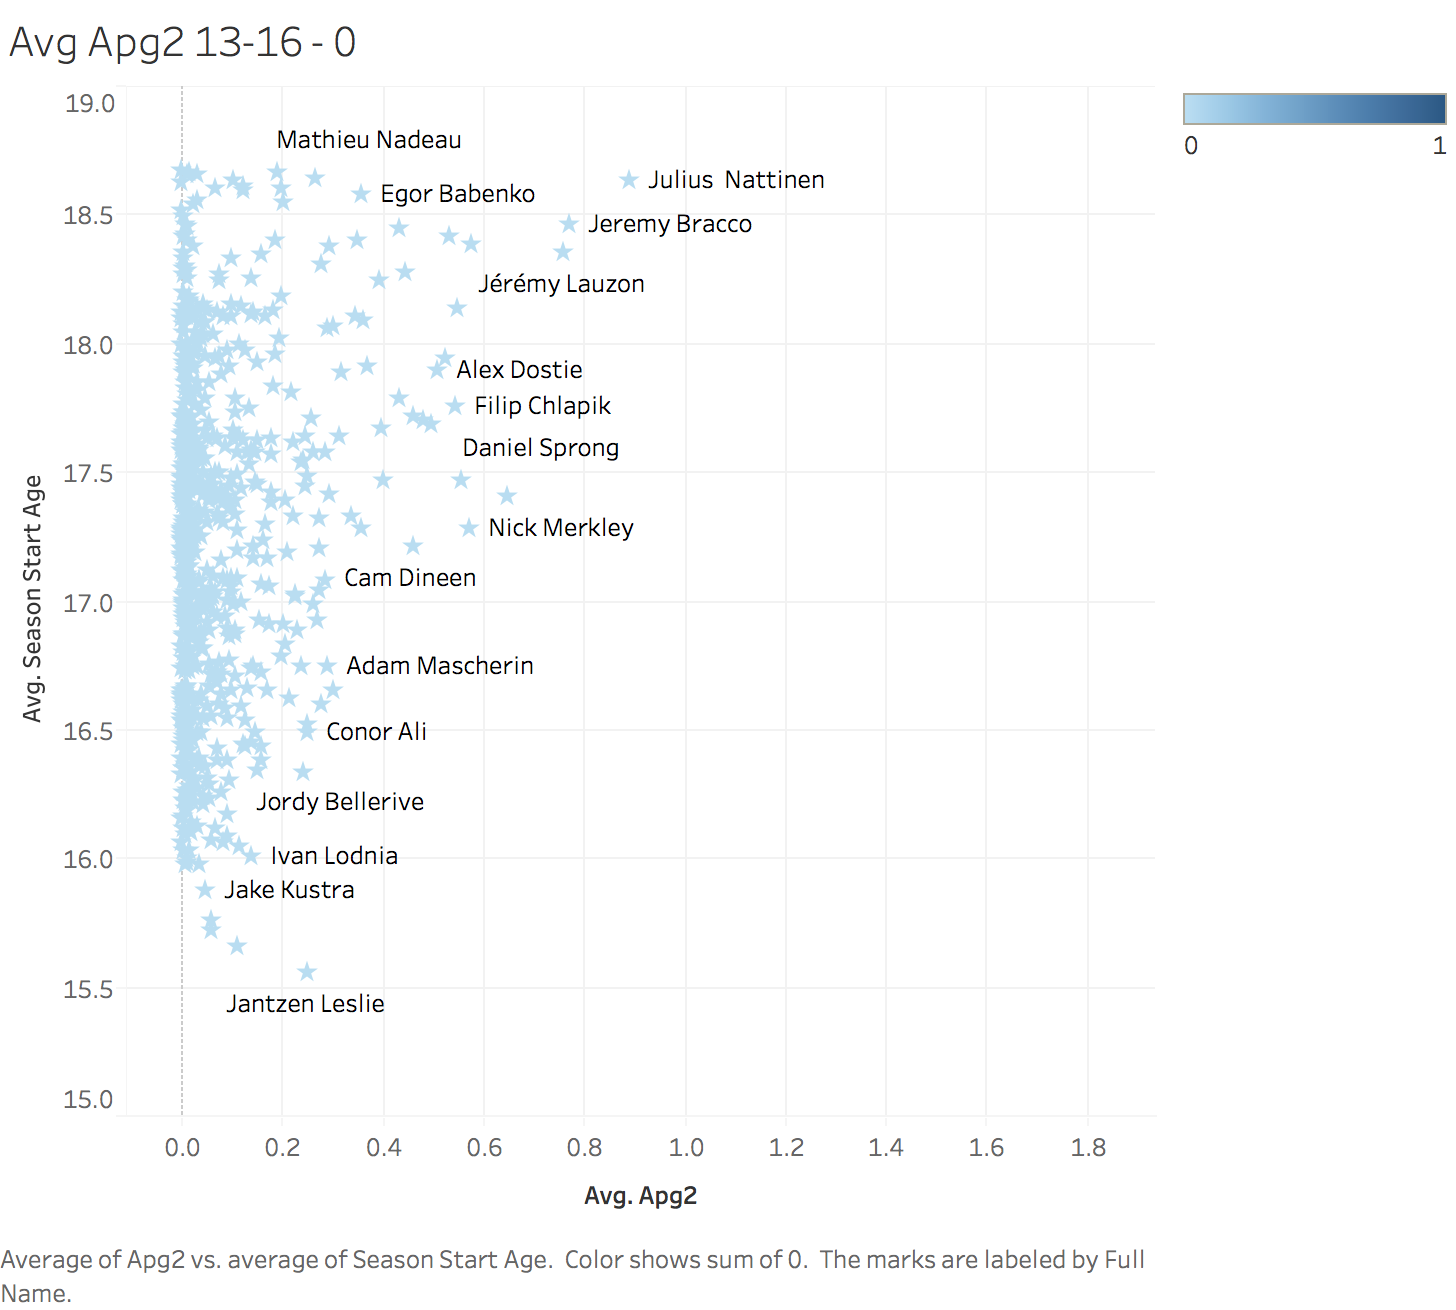

In [593]:
Image('/Users/gmaclenn/Desktop/Avg Apg2 13-16.png', width=800)

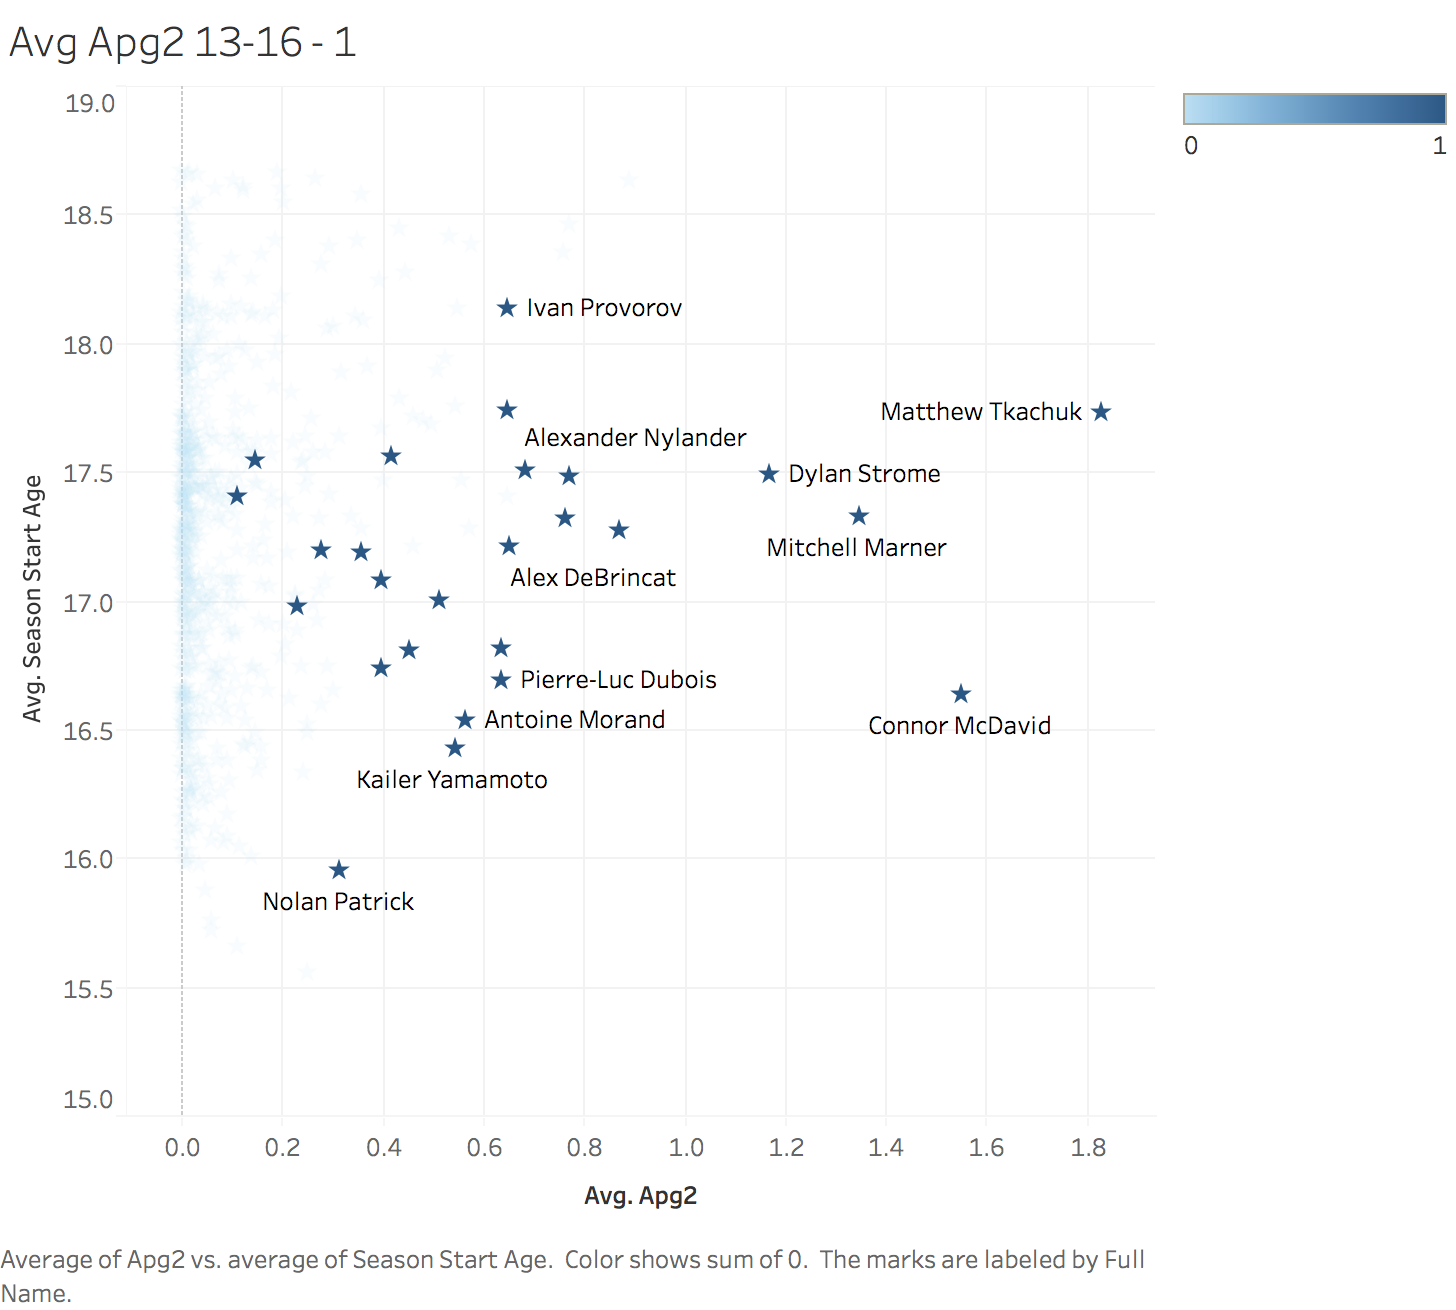

In [595]:
Image('/Users/gmaclenn/Desktop/Avg Apg2 13-16_overlay.png', width=800)

References 
1. Draft by Numbers: Using Data and Analytics to Improve National Hockey League (NHL) Player Selection 
Other Sports 1559 © Michael E. Schuckers, Statistical Sports Consulting, LLC 
2. http://canucksarmy.com/2015/5/26/draft-analytics-unveiling-the-prospect-cohort-success-model
3. http://www.theprojectionproject.com/Home/Search
4. http://hockeyanalytics.com/2004/12/league-equivalencies/

5. http://oilersnation.com/2015/1/23/development-and-the-200-game-mark
6. Data pulled from Hockey Reference
7. http://www.arcticicehockey.com/2010/1/21/1261318/nhl-points-per-game-peak-age?_ga=1.98974686.1956457380.1427732150
8. http://www.behindthenet.ca/projecting_to_nhl.php
9. http://hockeyanalytics.com/2004/12/league-equivalencies/
10. http://www.ohl.ca 
11. http://www.ontariohockeyleague.com
12. http://www.theqmjhl.ca
13. http://www.hockey-reference.com
14. http://www.thehockeynews.com/news/article/penguins-hire-war-on-ice-co-creator-want-to-build-analytics-team
15. https://hockey-graphs.com/2017/01/19/expected-primary-points-are-a-better-predictor-of-future-scoring-than-shots-points/